In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
#To create a Session Object to Connect to DB
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

print(Base)


<class 'sqlalchemy.ext.automap.Base'>


In [6]:
# View all of the classes that automap found by printing all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [9]:
# Beacuse I want to see the data: Get a list of column names and types for station
inspector_meas = inspect(engine)
columns = inspector_meas.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Beacuse I want to see the data: Display the station table's first row's columns and data in dictionary format
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fea5af64940>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716}

In [11]:
# Beacuse I want to see the data: Get a list of column names and types for station
inspector_stat = inspect(engine)
columns = inspector_stat.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Beacuse I want to see the data: Display the measurement table's first row's columns and data in dictionary format
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fea5f1d3e80>,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'tobs': 65.0}

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
#Do this by looking at the measurement date, sorting by desc so that the greatest date is first, and then listing the first date
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

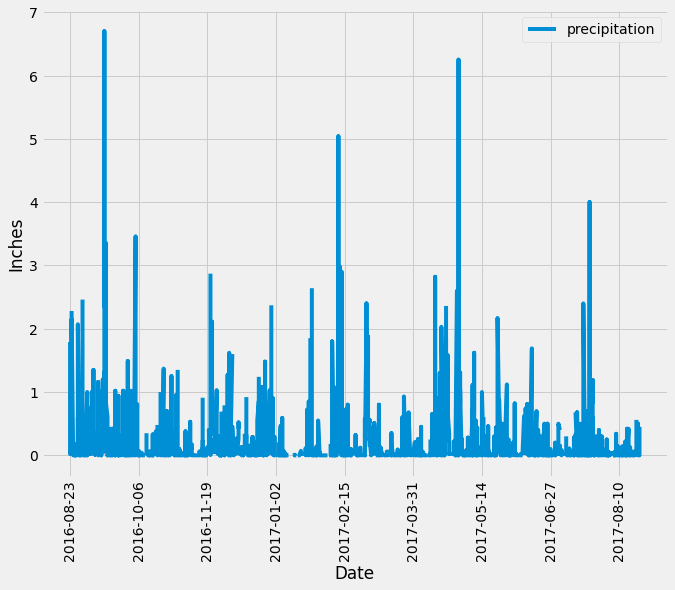

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent = datetime.strptime(most_recent[0], '%Y-%m-%d') #Result: datetime.datetime(2017, 8, 23, 0, 0)

# Calculate the date one year from the last date in data set.
year_ago = most_recent - dt.timedelta(days=365) #Result: datetime.datetime(2016, 8, 23, 0, 0)

#Convert year_ago back to string in YYYY-MM-DD format
year_ago = year_ago.strftime("%Y-%m-%d")
#year_ago #result: '2016-08-23'

#most_recent = most_recent.strftime("%Y-%m-%d")
#most_recent #result: '2017-08-23'

# Perform a query to retrieve the data and precipitation scores
data = engine.execute('SELECT date, prcp FROM measurement WHERE date >= ?', year_ago).fetchall()
#for record in data: 
#    print(record) #Result: ('2016-08-23', 0.0)...('2017-08-23', 0.45)

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data, columns=['date', 'prcp'] )
data_df = data_df.set_index('date')
# Sort the dataframe by date
data_df = data_df.sort_values(by='date', ascending=True)
#data_df

# Use Pandas Plotting with Matplotlib to plot the data
#create x and y axes
x_axis = data_df.index
y_axis = data_df['prcp']

#create the figure and axes; set the size
fig, ax = plt.subplots(figsize=(10, 8))

#reduce the number of xticks to 9, beginning with the starting date
ax.set_xticks(np.arange(0,2230, 44))
#rotate the xtick labels 90 degrees
ax.tick_params(axis='x', labelrotation = 90, )

#add axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Inches')

#plot and add legend
ax.plot(x_axis, y_axis, label="precipitation")
ax.legend()

plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
#create precipitation data array
precipitation = data_df['prcp']

#calculate mean while EXCLUDING nan
mean_numpy = np.nanmean(precipitation)
print(f"The mean precipitation amount in inches (while excluding nan) is {mean_numpy}")

#calculate median while EXCLUDING nan
median_numpy = np.nanmedian(precipitation)
print(f"The median precipitation amount in inches (while excluding nan) is {median_numpy}")

#calculate mode while EXCLUDING nan
mode_scipy = stats.mode(precipitation, nan_policy='omit')
print(f"The mode precipitation amount in inches is (while excluding nan) {mode_scipy}")

The mean precipitation amount in inches (while excluding nan) is 0.17727857496288968
The median precipitation amount in inches (while excluding nan) is 0.02
The mode precipitation amount in inches is (while excluding nan) ModeResult(mode=array([0.]), count=array([874.]))


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
#total_stations = engine.execute('SELECT COUNT(DISTINCT station) FROM measurement')

total_stations = session.query(measurement.station).group_by(measurement.station).count()
print(f'There are {total_stations} stations in the dataset.')

There are 9 stations in the dataset.


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_counts = engine.execute('SELECT station, count(*) AS station_count \
FROM measurement \
GROUP BY station \
ORDER BY count(*) DESC').fetchall()

# List the stations and the counts in descending order.
station_counts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_query = engine.execute('SELECT station \
FROM measurement \
GROUP BY station \
ORDER BY count(*) DESC \
LIMIT 1').fetchall()

active_station = active_station_query[0][0]
active_station
#lowest_temp = engine.execute('SELECT station, count(*) AS station_count \
#FROM measurement \
#GROUP BY station \
#ORDER BY count(*) DESC').fetchall()

'USC00519281'

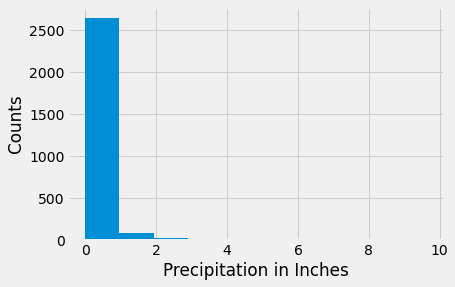

NormaltestResult(statistic=3744.5009238106218, pvalue=0.0)


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = engine.execute('SELECT date, prcp FROM measurement WHERE station LIKE ?', active_station)

#turn query into dataframe
temp_data_df = pd.DataFrame(temp_data, columns=['date', 'prcp'])

#create histogram; omit NAN
prcp_data = temp_data_df['prcp']
# Characterize the data set using matplotlib and stats.normaltest
plt.hist(prcp_data)
plt.xlabel('Precipitation in Inches')
plt.ylabel('Counts')
plt.show()
print(stats.normaltest(prcp_data.sample(2772), nan_policy='omit'))

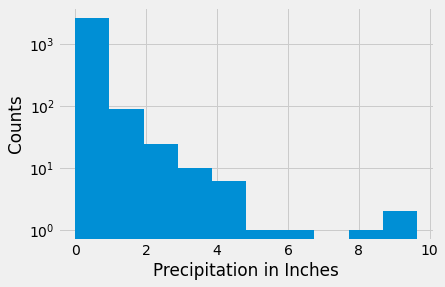

NormaltestResult(statistic=3744.5009238106218, pvalue=0.0)


In [20]:
#as an alternative view to better spot patterns and ID relationshoips, I've plotted prcp data with log scale; NAN is omitted
plt.hist(prcp_data)
plt.xlabel('Precipitation in Inches')
plt.ylabel('Counts')
plt.yscale('log')
plt.show()
print(stats.normaltest(prcp_data.sample(2772),nan_policy='omit'))

# Close session

In [21]:
# Close Session
session.close()